# **AM 207**: Homework 3

Verena Kaynig-Fittkau and Pavlos Protopapas  <br>
**Due: 11.59 P.M. Thursday March 24th, 2016**

### Instructions:

+ Upload your answers in an ipython notebook to Canvas.

+ We will provide you imports for your ipython notebook. Please do not import additional libraries.

+ Your individual submissions should use the following filenames: AM207_YOURNAME_HW3.ipynb

+ Your code should be in code cells as part of your ipython notebook. Do not use a different language (or format). 

+ **Do not just send your code. The homework solutions should be in a report style. Be sure to add comments to your code as well as markdown cells where you describe your approach and discuss your results. **

+ Please submit your notebook in an executed status, so that we can see all the results you computed. However, we will still run your code and all cells should reproduce the output when executed. 

+ If you have multiple files (e.g. you've added code files or images) create a tarball for all files in a single file and name it: AM207_YOURNAME_HW3.tar.gz or AM207_YOURNAME_HW3.zip


### Have Fun!
_ _ _ _ _

In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
sns.set_style("white")

import time
import timeit

import scipy.stats 
import pandas as pd
import pymc as pm

import re
import numpy as np

/Users/charlesliu/anaconda/lib/python2.7/site-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


# Problem 1: Employee Satisfaction Improvement
This problem is going to explore the differences between complete pooling, unpooling and partial pooling for a normal model with observed standard deviations. 

You are working for a consulting firm which is trying to find a good strategy to improve employee satisfaction for their customers. Your company ran pilot studies in eight different customer companies and measured the improvement in employee satisfaction after the plan had been implemented for two years. The data you are given is the mean and standard deviation of the satisfaction improvement, measured by a survey. 
You follow the nature of your data by modeling the effect of the strategie with a normal model. To simplify things you can assume that the different standard deviations are an effect of different sample sizes, and that there is actually one underlying observation variance:

$$ \sigma_j^2 = \frac{\sigma^2}{n_j}$$

Thus the difference in the observed standard deviations in the survey results are caused by having different numbers of survey answers $n_j$. 

Discuss, create and compare three different solutions for your model using PYMC or another sampling method of your choice:

* complete pooling
* unpooling
* partial pooling

In [2]:
# Here is the data
data = np.double(np.array([[29.5,18.4],[6.3,12.7],[-3.9,15.9],[7.2,10.2],[-2.1,9.0],[1.8,12.1],[19.6,7.3],[12,18.6]]))
data_means = data[:,0]
data_std = data[:,1]

 [-----------------100%-----------------] 100000 of 100000 complete in 3.7 secPlotting mu


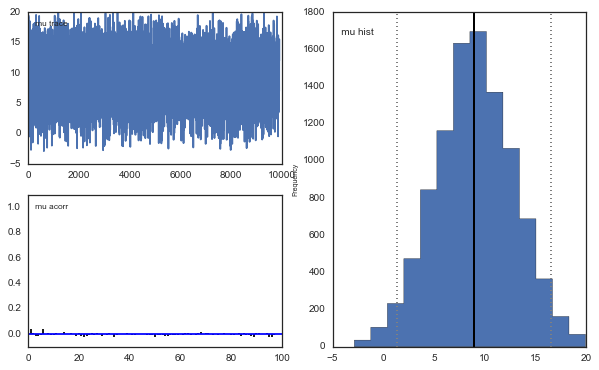

In [125]:
#Complete Pooling
mu = pm.Uniform("mu", -3., 20.)
improvements = pm.Normal("improvements", mu=mu, tau = 1/data_std**2, value = data_means, observed=True)
imp_model = pm.Model([mu, improvements])
mc = pm.MCMC(imp_model)
mc.sample(iter=100000, burn=1000, thin=10)
pm.Matplot.plot(mc)

In [126]:
print("Data mean:" + str(np.mean(data_means)))
print("Data std:" + str(np.std(data_means)))
print("Mu mean:" + str(np.mean(mu.trace())))
print("Mu std:" + str(np.std(mu.trace())))

Data mean:8.8
Data std:10.5669295446
Mu mean:8.9910745876
Mu std:3.86281731891


We essentially get a normal distribution around the average of the data_means which intuitively makes sense.

 [-----------------100%-----------------] 100000 of 100000 complete in 3.5 secPlotting mu
Data mean:29.5
Data std:18.4
Mu mean:29.9812318249
Mu std:2.8814804813
 [-----------------100%-----------------] 100000 of 100000 complete in 3.7 secPlotting mu
Data mean:6.3
Data std:12.7
Mu mean:5.0603096233
Mu std:2.83950277051
 [-----------------100%-----------------] 100000 of 100000 complete in 3.7 secPlotting mu
Data mean:-3.9
Data std:15.9
Mu mean:-3.0114627669
Mu std:2.87014270077
 [-----------------100%-----------------] 100000 of 100000 complete in 3.7 secPlotting mu
Data mean:7.2
Data std:10.2
Mu mean:6.99806566016
Mu std:2.82393736522
 [-----------------100%-----------------] 100000 of 100000 complete in 3.6 secPlotting mu
Data mean:-2.1
Data std:9.0
Mu mean:-1.98188125036
Mu std:2.81410564291
 [-----------------100%-----------------] 100000 of 100000 complete in 3.8 secPlotting mu
Data mean:1.8
Data std:12.1
Mu mean:1.89773673395
Mu std:2.84672369552
 [-----------------100%----------

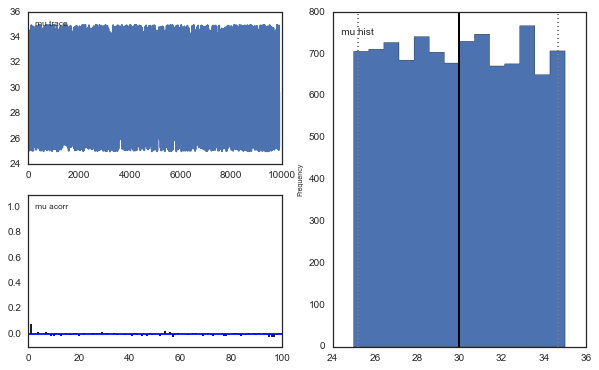

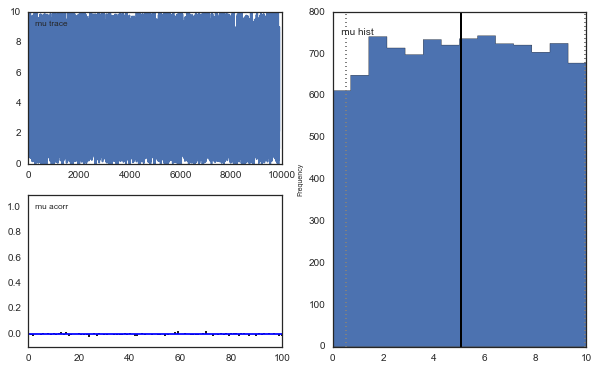

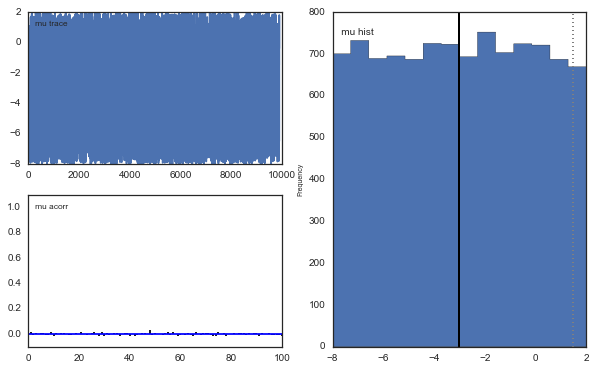

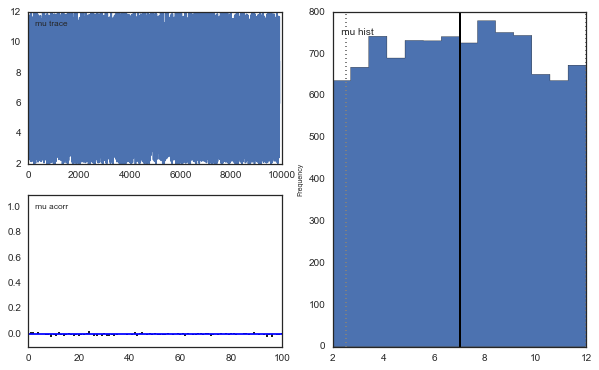

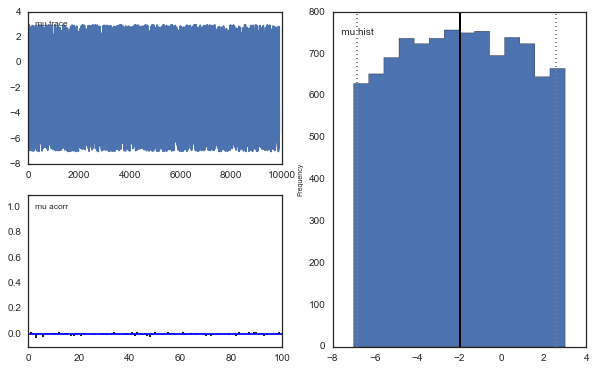

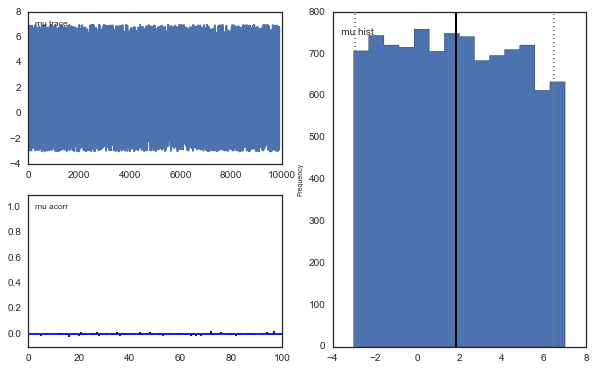

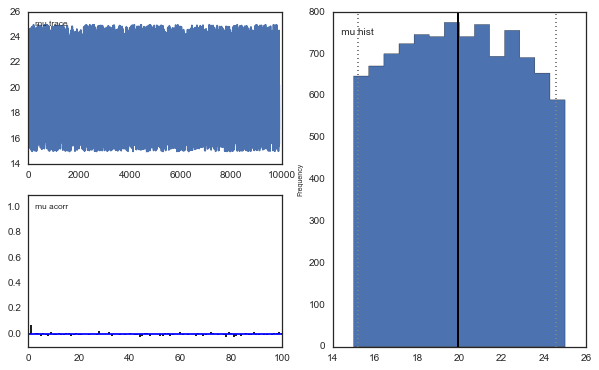

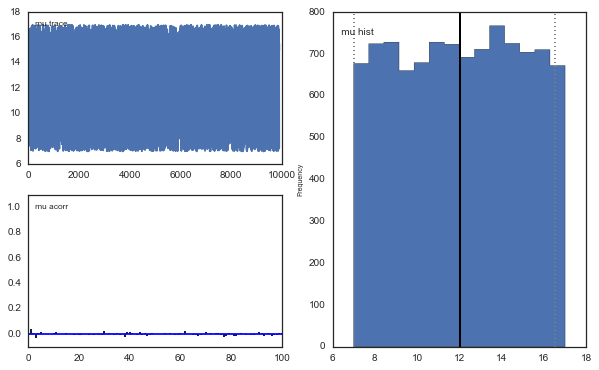

In [127]:
#Unpooling
highs = [35, 10, 2, 12, 3, 7, 25, 17]
lows = [25, 0, -8, 2, -7, -3, 15, 7]
for i in range(len(data_means)):
    mu = pm.Uniform("mu", lows[i], highs[i])
    improvements = pm.Normal("improvements", mu=mu, tau = 1/data_std[i]**2, value = data_means[i], observed=True)
    imp_model = pm.Model([mu, improvements])
    mc = pm.MCMC(imp_model)
    mc.sample(iter=100000, burn=1000, thin=10)
    pm.Matplot.plot(mc)
    print("Data mean:" + str(data_means[i]))
    print("Data std:" + str(data_std[i]))
    print("Mu mean:" + str(np.mean(mu.trace())))
    print("Mu std:" + str(np.std(mu.trace())))

In the case of unpooled data, we have separate priors for each data point and run the similar mcmc model as in the completely pooled

 [-----------------100%-----------------] 100000 of 100000 complete in 15.1 secPlotting sharedtau
Plotting sharednorm
Plotting sharedmu
Data mean:8.8
Data std:10.5669295446
Shared Norm mean:9.04872073832
Shared Norm std:3.88742814925


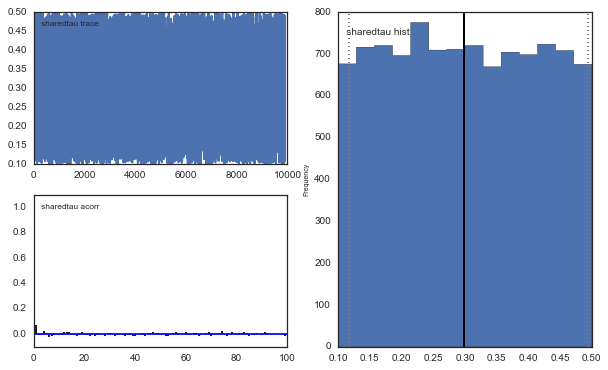

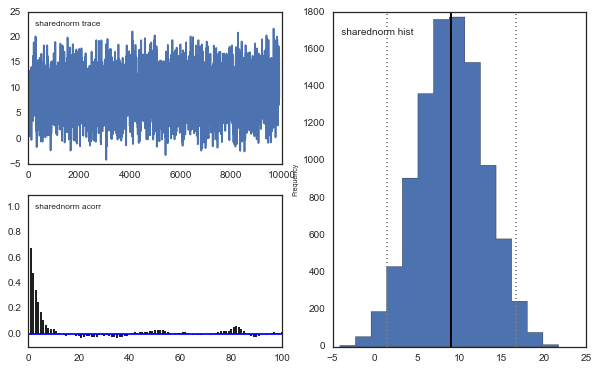

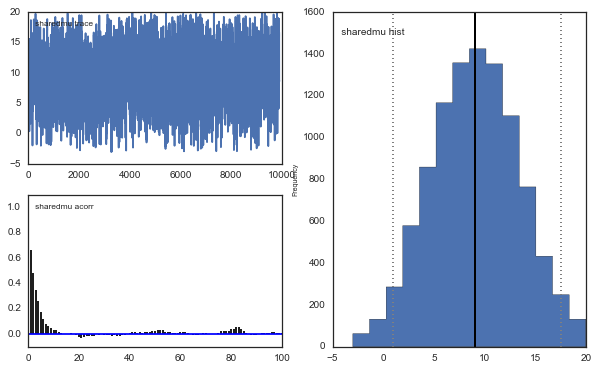

In [128]:
#partial pooling
sharedmu = pm.Uniform("sharedmu", -3., 20.)
sharedtau = pm.Uniform("sharedtau", 0.1, 0.5)
sharednorm = pm.Normal("sharednorm", mu=sharedmu, tau=sharedtau)
model_list = [sharedmu, sharedtau, sharednorm]
for i in range(len(data_means)):
    model_list += [pm.Normal("improvements"+str(i), mu=sharednorm, tau = 1/data_std[i]**2, value = data_means[i], observed=True)]
imp_model = pm.Model(model_list)
mc = pm.MCMC(imp_model)
mc.sample(iter=100000, burn=1000, thin=10)
pm.Matplot.plot(mc)
print("Data mean:" + str(np.mean(data_means)))
print("Data std:" + str(np.std(data_means)))
print("Shared Norm mean:" + str(np.mean(sharednorm.trace())))
print("Shared Norm std:" + str(np.std(sharednorm.trace())))

For partial pooling we create a hyperparameter of a normal distribution which each data point draws from. In the end, our shared norm mean is roughly the mean of data_means

# Problem 2: Motif Finding Using Gibbs

One interesting problem in bioinformatics is that of finding common subsequences of nucleotid bases (these subsequences are called motifs) that repeat themselves within larger DNA sequences. The problem is relevant for genetics because locating the positions of these motifs within the DNA sequence helps in the understanding of how genes are regulated.

Suppose that you are a biologist who is analyzing genetic material collected in a nearby asteroid. The DNA of this extraterrestrial form of life is formed as a sequence of $n_B = 5$ nucleotide bases. Let us label these extraterrestrial nucleotides and put them in a vector $\mathbf{b} = [\rm{M}, \rm{0}, \rm{2}, \rm{A}, \rm{7}]$. You have a DNA sample $\mathcal{S}$ consisting of $p=20$ sequences of DNA, each of them with a lenght $l=200$ nucleotide bases that you can find in <a href="HW3/Sequences_new.dat">this file</a>. Each row of the file is a DNA sequence. You are asked to find a motif of $q = 5$ consecutive nucleotides hidden in the background that appears to repeat itself very often in the DNA you were given, but that appears only once in each of the sequences.

Let us formalize the problem. The starting positions of the motif within each sequence (our missing data in the problem) can be represented by the set of random variables:

$$
\mathcal{A} = \left\{a_k, k = 1,...,p\right\}
$$

The motif has to start somewhere within the sequences and so for each sequence $\mathcal{S_k}$:

$$
\sum_{i=1}^{l}P(a_k=i) = 1
$$

What we are after is the joint distribution $P(\mathcal{A}|\mathcal{S})$ for the motif alignment (i.e., its starting position) being $a_k$ for sequence $\mathcal{S}_k$. As shown in [this paper](http://www.cs.cmu.edu/~epxing/Class/10810/readings/liu.pdf), for each sequence $\mathcal{S}_k$ (think of each sequence as a dimension of our parameter space) we can obtain the conditional probability: 

$$
P(a_k=i|\mathcal{A_{\hat{k}}},\mathcal{S})=\frac{1}{Z}\prod_{j=1}^q\left(\frac{\mathbf{\hat{\theta}_j}}{\mathbf{\hat{\theta}_0}}\right)^{s_{i+j-1}}
$$

where $\mathcal{A_{\hat{k}}}$ refers to the alignments in all sequences other than $\mathcal{S}_k$, and $Z$ is a normalization factor. Of the other quantities, $s_x$ is a vector index for the *x-th* position in the sequence, with the same length as $\mathbf{\hat{\theta_j}}$ and $\mathbf{b}$. It takes a value of 1 at the entry that in $\mathbf{b}$ corresponds to the base at position $x$ and 0 for all other entries. Finally, vectors $\mathbf{\hat{\theta_j}}$ and $\mathbf{\hat{\theta_0}}$ contain respectively the probabilities of observing the $q$ bases at the corresponding position of the current sequence, and the probabilities of finding the same bases in the background. It is important to note that the power, division, and multiplication of vectors in the equation above is performed entry-wise.

Your only task is to design a Gibbs algorithm that samples the joint probability $P(\mathcal{A}|\mathcal{S})$. Your algorithm should converge and provide the alignments of the motif and the secret motif itself. Here are some hints/tasks that should help you and that will help the TF grading your homework:

(a) Describe the equation for the conditional probabilities in your own words, and make sure you understand it before you code anything. Be as explicit as possible.

(b) Start by assigning random starting positions for the $q$-long motif in all sequences. Then exclude a particular sequence $S_k$ (your current sequence) and use the remaining sequences to construct $\mathbf{\Theta}$ as a probability matrix from counting the number of times that the *i-th* base appears in position $j$ of the motif given the current alignments. Construct also a vector $\mathbf{\hat{\theta_0}}$ from counting the number of times that the *i-th* base appears in the background. Note that the vectors $\mathbf{\hat{\theta_j}}$ are the columns of matrix $\mathbf{\Theta}$.

(c) From $\mathbf{\Theta}$ and $\mathbf{\theta_0}$, derive the conditional probability over all possible alignments for your current sequence and draw a sample from it. This sample will be your updated alignment for the current sequence.

(d) Iterate over all $p$ sequences. Such iteration over sequences is only one Gibbs iteration. After enough Gibbs iterations you should start noticing that the algorithm has converged.


I found the notation to be quite confusing. I believe the conditional probability should be calculated in the following way:

You create a matrix that gives you P(X,i) for any nucleotide X and index i$\in [1,...,q]$. You also have the background probabilities B(X) (part b)

Now you look at the sequence starting at some position i - suppose that resulting sequence is "AM207". The conditional probability is then:

$$
P(a_k = i|S,A) = \frac{P(A,1)*P(M,2)*P(2,3)*P(0,4)*P(7,5)}{B(A)*B(M)*B(2)*B(0)*B(7)}
$$

Essentially the probability of getting that sequences with your probability table and then divided by just getting those combination of letters

In [2]:
#get sequences from file and set up dictionary for vector indices
b = {"A":0, "M":1, "2":2, "0":3, "7":4}
sequences = []
with open("HW3/Sequences_new.dat") as f:
    sequences = map(lambda x: x[0:200], f.readlines())
q = 5

In [27]:
#random positions to start
positions = np.random.randint(0, len(sequences[0])-q+1, len(sequences))

#track all positions and set max iterations and convergence requirement
max_iter = 1000
positions_hist = np.zeros((len(sequences), max_iter+1))
positions_hist[:, 0] = positions
converged_req = 5

#have a minimum probability requirement so no nucleotide's probability is 0
mp_sum = 1.0
mp = mp_sum/len(b)
#background counts for each iteration
bg_count = (len(sequences)-1)*(len(sequences[0]) - q)

bg_denom = bg_count + mp_sum
nucleo_denom = len(sequences)-1 + mp_sum

iters = 0
converged_count = 0
while iters < max_iter and converged_count < converged_req:
    iters += 1
    for i in xrange(len(sequences)):
        #start with minimum probabilities required
        nucleotide_prob = np.ones((len(b), q))*mp
        background_prob = np.ones(len(b))*mp
        #populate counts of each letter
        for j in xrange(len(sequences)):
            if j != i:
                sequence = sequences[j]
                for k in xrange(len(sequence)):
                    if k >= positions[j] and k < positions[j] + q:
                        nucleotide_prob[b[sequence[k]]][k - positions[j]] += 1
                    else:
                        background_prob[b[sequence[k]]] += 1

        #update to probabilities
        background_prob /= bg_denom
        nucleotide_prob /= nucleo_denom

        #now we create an array of probabilities of subsequence in sequences[i] and sample from it
        prob_dist = np.ones(len(sequences[i])-q+1)
        for j in xrange(len(prob_dist)):
            for k in xrange(q):
                prob_dist[j] *= nucleotide_prob[b[sequences[i][j+k]]][k]/background_prob[b[sequences[i][j+k]]]
        prob_dist /= np.sum(prob_dist)

        #sample according to the uniform
        positions[i] = np.random.choice(len(prob_dist),p=prob_dist)
        
    positions_hist[:, iters] = positions
    #check if we've gotten the same distribution converged_req times in a row
    if converged_req < iters:
        if np.sum(positions_hist[:, iters] == positions_hist[:, iters-1]) == len(sequences):
            converged_count += 1
        else:
            converged_count = 0
        
print("Iterations Required:" + str(iters))
for i in xrange(len(sequences)):
    print("Sequence " + str(i) + ": Position " + str(positions[i]) + ": String: " + sequences[i][positions[i]:positions[i]+q])

Iterations Required:76
Sequence 0: Position 62: String: AM207
Sequence 1: Position 150: String: AM207
Sequence 2: Position 30: String: AM207
Sequence 3: Position 153: String: AM207
Sequence 4: Position 26: String: AM207
Sequence 5: Position 57: String: AM207
Sequence 6: Position 51: String: AM207
Sequence 7: Position 97: String: AM207
Sequence 8: Position 70: String: AM207
Sequence 9: Position 154: String: AM207
Sequence 10: Position 37: String: AM207
Sequence 11: Position 124: String: AM207
Sequence 12: Position 61: String: AM207
Sequence 13: Position 85: String: AM207
Sequence 14: Position 165: String: AM207
Sequence 15: Position 124: String: AM207
Sequence 16: Position 84: String: AM207
Sequence 17: Position 144: String: AM207
Sequence 18: Position 44: String: AM207
Sequence 19: Position 88: String: AM207


There's some variability in these results - many times I get into the general vicinity of the solution, but perhaps the 207 will be in the middle so all the strings are of the form "M207X" where X is something random. Perhaps a lot more iterations will make this converge, but then the runtime becomes very long

# Problem 3: Optimizing Hand Luggage

You are going on a trip and have to optimize your hand luggage, but thanks to your cheap flight ticket, the weight of the hand lugagge is restricted and you are sure the airline will enforce the upper limit. You have a set of presents that you want to bring to the relatives you are visiting, but you have to notice that they don't all fit into your suitcase. 

This problem is also called the knapsack problem: given a set of items, each has its weight and value, determine which items should be included into your suitcase, so that the total weight does not exceed some value $W$ and the total value is maximal. The kind of the knapsack problem when each item can be included into the collection at most once is called the 0/1 knapsack problem. Your task is to solve this problem using simulated annealing. 

Implement simulated annealing to solve this problem with the list of items below. Which ones would you pick for your suitcase? Plot and discuss your optimization scheme and results. 
Compare your solution to a greedy algorithm, which sorts the items by the ratio $\frac{v_i}{w_i}$ and puts them into the suitcase consecutively.

In [3]:
# here is your data:

#number_of_data_points
N = 100

#total_weight_limit 
W = 3000

# weight of all the different items
w = np.array([  38,  236,  909,   73,  768,  906,  716,  646,  848,  961,  145,
        130,  973,  584,  750,  509,  391,  282,  179,  277,  255,  358,
        915,  469,  908,  253,  491,  669,  926,  399,  563,  581,  216,
        984,  754,  504,  479,  865,   87,  142,  394,    8,  320,  830,
        535,  314,  514,  897,  317,  210,  265,  729,  654,  628,  432,
        634,  457,  543,   72,  388,  455,  918,  562,  314,  516,  965,
        793,  498,   44,  589,   27,  821,  337,  622,  884,  298,  467,
         16,   65,  197,   26,  368,  739,  472,  904,  283,  666,  617,
         23,  778,  708, 1000,  127,  280,  382,  357,  156,  934,  314,
        596])

# value of all different items
v = np.array([36, 38, 30, 32, 40, 45, 45, 37, 49, 40, 44, 30, 31, 47, 43, 33, 30,
       43, 36, 50, 36, 32, 42, 41, 37, 43, 38, 41, 42, 41, 50, 34, 37, 37,
       43, 34, 46, 48, 30, 43, 40, 47, 37, 40, 50, 30, 42, 31, 39, 48, 49,
       31, 32, 42, 37, 32, 40, 30, 39, 48, 36, 32, 37, 37, 46, 45, 35, 47,
       40, 50, 46, 35, 43, 47, 48, 31, 50, 40, 30, 37, 30, 49, 47, 44, 43,
       50, 50, 41, 36, 43, 45, 39, 32, 37, 35, 34, 35, 38, 43, 47])

In [88]:
#greedy algorithm
v_w_i = map(lambda x: (v[x], w[x], x), range(N))
vw_ratio = sorted(map(lambda x: (x, x[0]*1./x[1]), v_w_i), key= lambda x: -x[1])
greedy_val = 0
greedy_weight = 0
index = 0
greedy_bag = []
while greedy_weight + vw_ratio[index][0][1] < W:
    print(vw_ratio[index])
    greedy_val += vw_ratio[index][0][0]
    greedy_weight += vw_ratio[index][0][1]
    greedy_bag += [vw_ratio[index][0][2]]
    index += 1
    
print("Value:" + str(greedy_val))
print("Weight:" + str(greedy_weight))

((47, 8, 41), 5.875)
((40, 16, 77), 2.5)
((46, 27, 70), 1.7037037037037037)
((36, 23, 88), 1.5652173913043479)
((30, 26, 80), 1.1538461538461537)
((36, 38, 0), 0.94736842105263153)
((40, 44, 68), 0.90909090909090906)
((39, 72, 58), 0.54166666666666663)
((30, 65, 78), 0.46153846153846156)
((32, 73, 3), 0.43835616438356162)
((30, 87, 38), 0.34482758620689657)
((44, 145, 10), 0.30344827586206896)
((43, 142, 39), 0.30281690140845069)
((32, 127, 92), 0.25196850393700787)
((30, 130, 11), 0.23076923076923078)
((48, 210, 49), 0.22857142857142856)
((35, 156, 96), 0.22435897435897437)
((36, 179, 18), 0.2011173184357542)
((37, 197, 79), 0.18781725888324874)
((49, 265, 50), 0.18490566037735848)
((50, 277, 19), 0.18050541516245489)
((50, 283, 85), 0.17667844522968199)
((37, 216, 32), 0.17129629629629631)
Value:897
Weight:2806


In [87]:
#simulated annealing
get_val = lambda bag: np.sum(map(lambda x: v[x], bag))
get_weight = lambda bag: np.sum(map(lambda x: w[x], bag))

#transition function for bag that's input is a tuple (in_bag, not_in_bag) of indices
#randomly choose num_flips to insert into bag
#randomly take out of bag if over W
def new_bag(in_out, num_flips):
    new_ins = np.random.choice(in_out[1], num_flips, replace=False)
    for new_in in new_ins:
        in_out[1].remove(new_in)
        in_out[0].append(new_in)
    while get_weight(in_out[0]) > W:
        rand_in = np.random.choice(in_out[0])
        in_out[1].append(rand_in)
        in_out[0].remove(rand_in)
        
temperature = 3.0
#start with the greedy_bag as initial
in_out = (greedy_bag, list(set(range(N)) - set(greedy_bag)))
prev_E = greedy_val
E_list = [greedy_val]
best_bag = greedy_bag
best_val = greedy_val
m = 1000
ftol = 0.01

for i in xrange(10000):
    num_flips = np.max([1,np.floor(np.sqrt(temperature)).astype(int)])
    new_path = (in_out[0][:], in_out[1][:])
    new_bag(new_path, num_flips)
    new_E = get_val(new_path[0])
    deltaE  =  new_E - prev_E 
    if deltaE > 0 or np.random.rand() > np.exp( -deltaE/temperature):
        if best_val < new_E:
            best_bag = new_path[0]
            best_val = new_E
        in_out = new_path
        prev_E = new_E
        E_list.append(new_E)
    
    if len(E_list) % 100 == 0:
        temperature *= 0.9
        if temperature < 0.01:
            temperature = 1.0
    
    if len(E_list) > m and np.std(E_list[-m:])/np.mean(E_list[-m:]) < ftol:
        break

print("Value:" + str(best_val))
print("Weight:" + str(get_weight(best_bag)))

Value:916
Weight:2995


In [89]:
#Comparison of bags
print(sorted(best_bag))
print(sorted(greedy_bag))

[0, 3, 10, 17, 18, 19, 25, 38, 39, 41, 49, 50, 58, 68, 70, 77, 78, 79, 80, 85, 88, 92, 96]
[0, 3, 10, 11, 18, 19, 32, 38, 39, 41, 49, 50, 58, 68, 70, 77, 78, 79, 80, 85, 88, 92, 96]


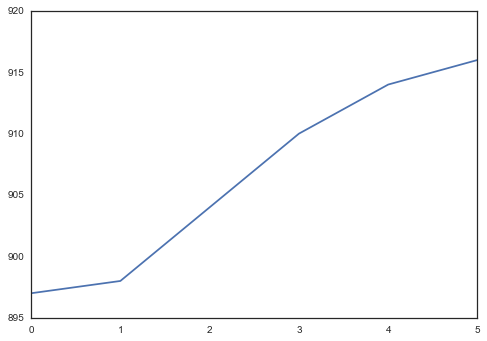

In [90]:
plt.plot(E_list)

The simulated annealing outperformed the greedy solution, mainly because it found a better mixture of items to maximize the weight while still having reasonable value/weight ratio. The method of transitioning bags was to randomly choose some number of items not in the bag to put in based on temperature, then randomly removing items in the bag if it violated the weight constraint.

# Problem 4: Confusing Classifications

You are a graduate student conducting research in image processing.  You want to test out your latest algorithm, which you decide to call "Ultra-Multilayer Hierarchical Super Convolutionary Neural Network."  However, in order to test out your algorithm, you need a sizable training data set. Luckly, your advisor has generously given you over 10 GB of over one million stock photos of cats and dogs.  Unfortunately, none of the images are labelled.  Fantastic!  You enjoy looking at photos of puppies and kittens in your spare time anyways so you decide to dedicate this entire weekend to labeling all of them. 

<table>
<tr>
 <td><img src="HW3/cat.jpeg" width=150>
 </td>
 <td><img src="HW3/dog.jpeg" width=150>
 </td>
</tr>
</table>

However, after spending two hours looking over hundreds of images, these puppies and kittens are no longer looking so cute.  In fact, you are starting to get disgusted at the idea of looking at another picture of these furry creatures.  

At this time, you decide to tap into the "power of the crowd" by farming out the labeling task to the workers of Amazon Mechanical Turk (MTurk). You decide to hire 3 MTurk workers.  However, you're not sure if these workers are reliable. So, how can you quantify the competency of the workers? In this problem you will develop a model to access the general difficulty of labeling the images of your two classes. 

Classifying items in general can be hard even for humans.  Some items just look alike, even if they actually are from two different classes. The difficulty in categorizing items of a specific class in relation to other classes is summarized by a [confusion matrix](https://en.wikipedia.org/wiki/Confusion_matrix):

$$ \Theta = \left( 
\begin{array}{cc}
1.0 & 0.0 \\
0.5 & 0.5
\end{array}
\right ) $$

This confusion matrix indicates that items of class 1 are very easy to classify, and always correctly labeled, whereas items of class 2 are very hard to classify and labels are basically just random guesses between the two possibilities. 

The models we discussed so far in homework and lecture were pretty low in dimensions. This problem is going to show you that the number of dimensions can grow very fast for some models, making a good sampling strategy crucial. We will only be able to explore a very minimal version of the problem, because of our limited computational resources, but it should be immediately clear how this model would scale for a greater number of classes, workers, and/or items.

Develop a Bayesian model that takes as input a set of (possible erroneous) item labelings and infer the underlying confusion matrix and the true label each data point. To make the model manageable by your laptop, use only one underlying confusion matrix (in principle different people could have different difficulties) two classes for the labels (the confusion matrix is 2x2), and a maximum of 150 data points. 

The model you are after is displayed in the following dependency graph:
<img src="HW3/confusion_model.png" alt="confusion matrix model" width=300>


$$\rho \sim Dir(\alpha) $$

$$z_i \sim Multinomial(\rho)$$

\begin{equation}
\Lambda = \begin{bmatrix}
 \lambda_1 \\
 \lambda_2 \\
\end{bmatrix}
\end{equation}

$$\Theta_{(k,:)} \sim Dir(\lambda_k)$$

$$r_{i,j} \sim Multinomial(\Theta_{(z_i , : )}), \ \forall j \in \{1,...,J\}$$

You're given reports generated by the 3 workers, so $r_{i,1}$ is one label for item $r_i$ and $r_{i,2}$ is another label given from another worker. Note that if the confusion matrix is not the identity matrix then these labels can be different because the workers make mistakes. The arrows in the diagram indicate dependence. So the labelings you observe are dependent on the confusion matrix $\Theta$ and the underlying true label $z_i$ for each item. $N$ is the number of data points you have and as described above you should use $N \leq 150$.

You can see from the diagram that the model uses Multinomials with Dirichlet priors. 

1. Start by describing the model in terms of these distributions, what they mean and what this arrangement means for the form of the labels $z_i$. Discuss the meaning and influence of the hyperparameter $\alpha$ on the true labels of the data.

2. Discuss your selection of the hyperparameter $\Lambda$ and how that influences the confusion matrix $\Theta$.

3. Implement this Bayesian model and sample from the posterior to recover the underlying confusion matrix $\Theta$ and the distribution of the true labels $\rho$.  Note: $\Theta$ is shared by all three workers.

In [ ]:
# Here is your data

reports = np.load("HW3/reports.npy")